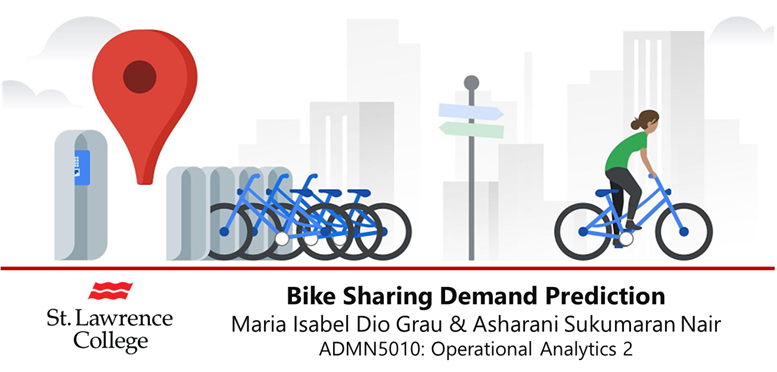

<i>This Python notebook contains a combination of markdown text and code block comments that explain the tasks being executed.</i><br>
***
### Client background
Because of the COVID-19 pandemic, bike-sharing company, BoomBikes, suffered a decline in earnings. Recognizing that it may take a while to recover from the economic downturn, the company would like to develop a machine learning model that can predict demand for bikes based on several factors.

### Dataset description
The company was able to gather data on the daly bike demand from 2018-2019, including several factors that could have affected these demand levels. This dataset consists of 730 observations/days, with the following columns:
* instant - id



The following script can be broken down into the following tasks (each line is linked to the code block that executes the corresponding step):
1. <a href='#extract'>Extract dataset from GitHub</a>
2. <a href='#process'>Data exploration and data cleaning</a>
3. <a href='#regression'>Demand prediction</a>

***
Before running the program, packages must first be imported in order to access the various functions used by the codes below. If necessary, the packages must first be installed with `pip install [package name]`

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import time
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lars
from sklearn.linear_model import TheilSenRegressor
from sklearn.linear_model import HuberRegressor
from sklearn.linear_model import PassiveAggressiveRegressor
from sklearn.linear_model import ARDRegression
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import OrthogonalMatchingPursuit
from sklearn.svm import SVR
from sklearn.svm import NuSVR
from sklearn.svm import LinearSVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.isotonic import IsotonicRegression
from sklearn.ensemble import RandomForestRegressor

In [5]:
df = pd.read_csv("bikesharing.csv")

In [6]:
df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


### Data Exploration and Data Cleaning

In [7]:
df.shape

(730, 16)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


In [9]:
# Add column day
df['day'] = df['dteday'].apply(lambda x: x[0:2])
df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,day
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985,01
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801,02
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349,03
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562,04
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600,05


In [10]:
# Check tail if day column is correct

df.tail()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,day
725,726,27-12-2019,1,1,12,0,4,1,2,10.420847,11.33210,65.2917,23.458911,247,1867,2114,27
726,727,28-12-2019,1,1,12,0,5,1,2,10.386653,12.75230,59.0000,10.416557,644,2451,3095,28
727,728,29-12-2019,1,1,12,0,6,0,2,10.386653,12.12000,75.2917,8.333661,159,1182,1341,29
728,729,30-12-2019,1,1,12,0,0,0,1,10.489153,11.58500,48.3333,23.500518,364,1432,1796,30
729,730,31-12-2019,1,1,12,0,1,1,2,8.849153,11.17435,57.7500,10.374682,439,2290,2729,31


In [11]:
# Change dteday type to date

df['dteday'] = pd.to_datetime(df['dteday'], format='%d-%m-%Y')
df['day'] = pd.to_numeric(df['day'])
df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,day
0,1,2018-01-01,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985,1
1,2,2018-01-02,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801,2
2,3,2018-01-03,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349,3
3,4,2018-01-04,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562,4
4,5,2018-01-05,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600,5


Since dteday is correlated with yr, month, day, this will not be part of the regression. However, it will be used to visualize the trend in demand

In [12]:
# No null values

df.isnull().sum()

instant       0
dteday        0
season        0
yr            0
mnth          0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
day           0
dtype: int64

The following columns should be dropped:
- instand - ID number, no predictive power, unnecessary since the dataframe already has an index
- season - correlated with month
- atempt - correlated with temp
- casual and registered - casual + registered = cnt<br>
<t><t>This would help if the company's products differed between casual and registered bikers. However, the dataset does not specify the difference between the two, so these will be dropped.

In [13]:
# Drop the following: instant, atemp, casual, registered (cnt = casual + registered)

df = df.drop(['instant', 'season', 'atemp', 'casual', 'registered'], axis = 1)
df.head()

,dteday,yr,mnth,holiday,weekday,workingday,weathersit,temp,hum,windspeed,cnt,day
0,2018-01-01,0,1,0,6,0,2,14.110847,80.5833,10.749882,985,1
1,2018-01-02,0,1,0,0,0,2,14.902598,69.6087,16.652113,801,2
2,2018-01-03,0,1,0,1,1,1,8.050924,43.7273,16.636703,1349,3
3,2018-01-04,0,1,0,2,1,1,8.200000,59.0435,10.739832,1562,4
4,2018-01-05,0,1,0,3,1,1,9.305237,43.6957,12.522300,1600,5


In [14]:
df.shape

(730, 12)

In [15]:
# Get statistics of numeric columns
numeric_columns = ['temp', 'hum', 'windspeed', 'cnt']
df[numeric_columns].describe().T


,count,mean,std,min,25%,50%,75%,max
temp,730.0,20.319259,7.506729,2.424346,13.811885,20.465826,26.880615,35.328347
hum,730.0,62.765175,14.237589,0.000000,52.000000,62.625000,72.989575,97.250000
windspeed,730.0,12.763620,5.195841,1.500244,9.041650,12.125325,15.625589,34.000021
cnt,730.0,4508.006849,1936.011647,22.000000,3169.750000,4548.500000,5966.000000,8714.000000


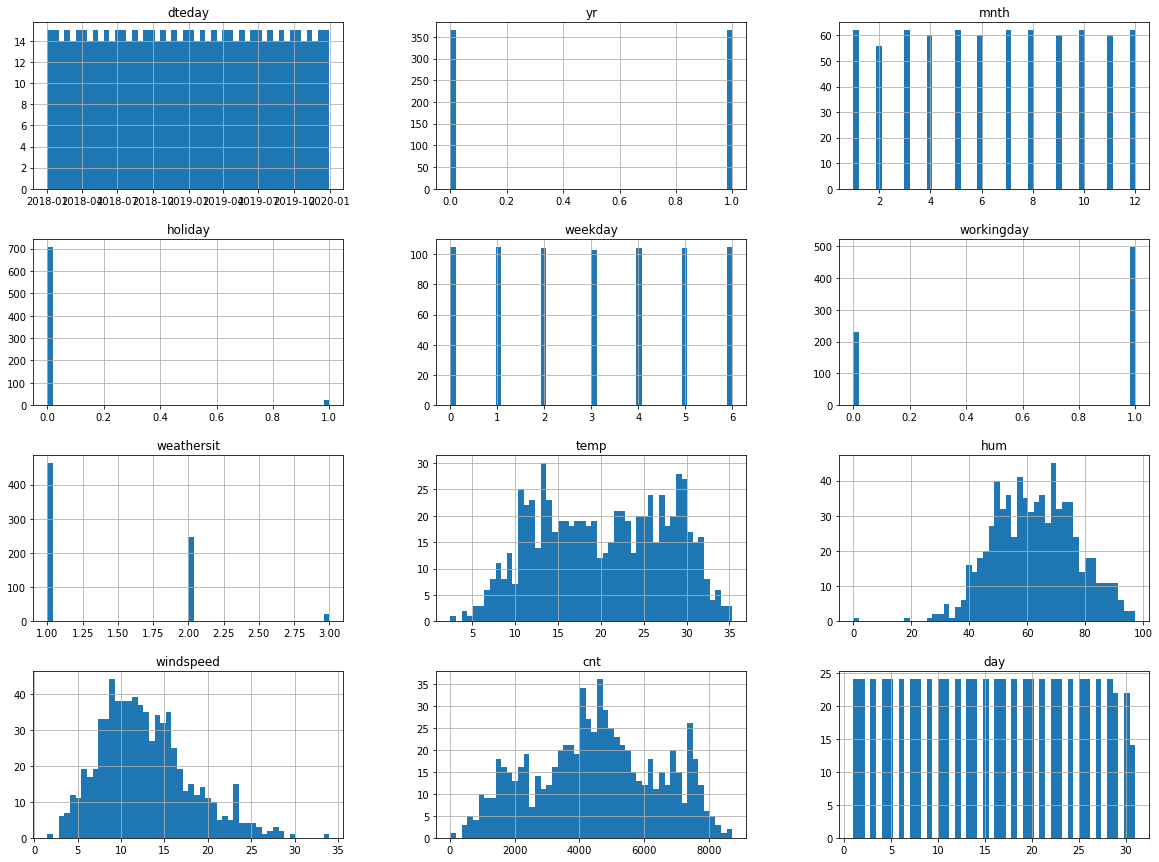

In [16]:
# All
df.hist(bins=50, figsize=(20,15))
plt.show()

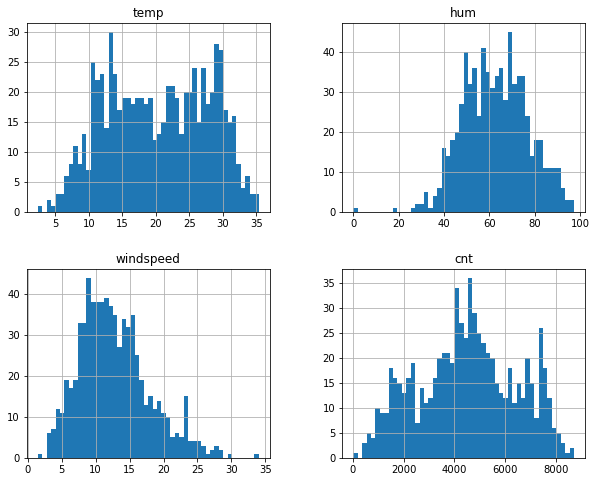

In [17]:
# Numerical only
df[numeric_columns].hist(bins=50, figsize=(10,8))
plt.show()

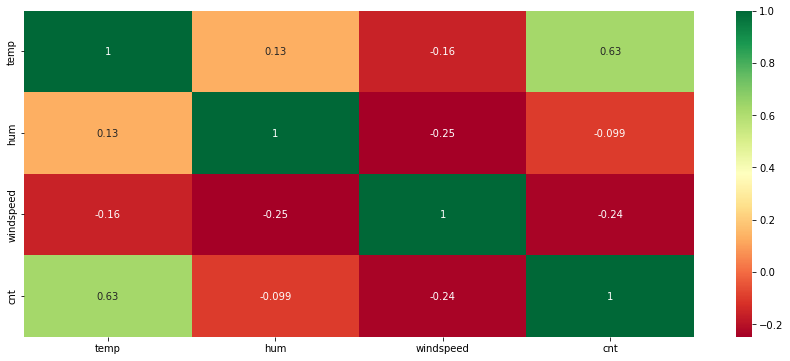

In [18]:
# Create a heatmap

plt.figure(figsize=(15,6))
heatmap = sns.heatmap(df[numeric_columns].corr(), annot=True, cmap="RdYlGn")

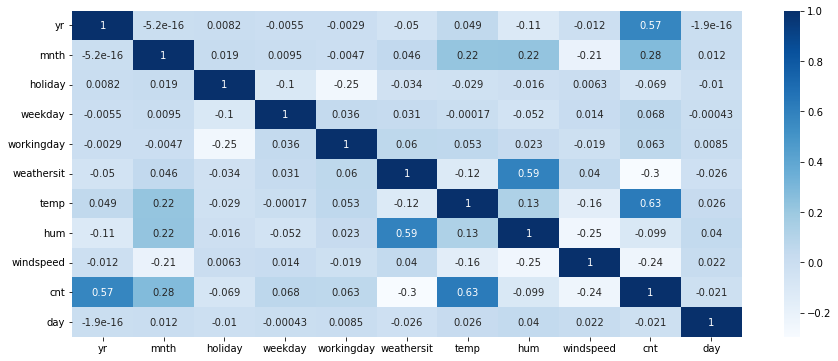

In [19]:
# All

plt.figure(figsize=(15,6))
heatmap = sns.heatmap(df.corr(), annot=True, cmap="Blues")

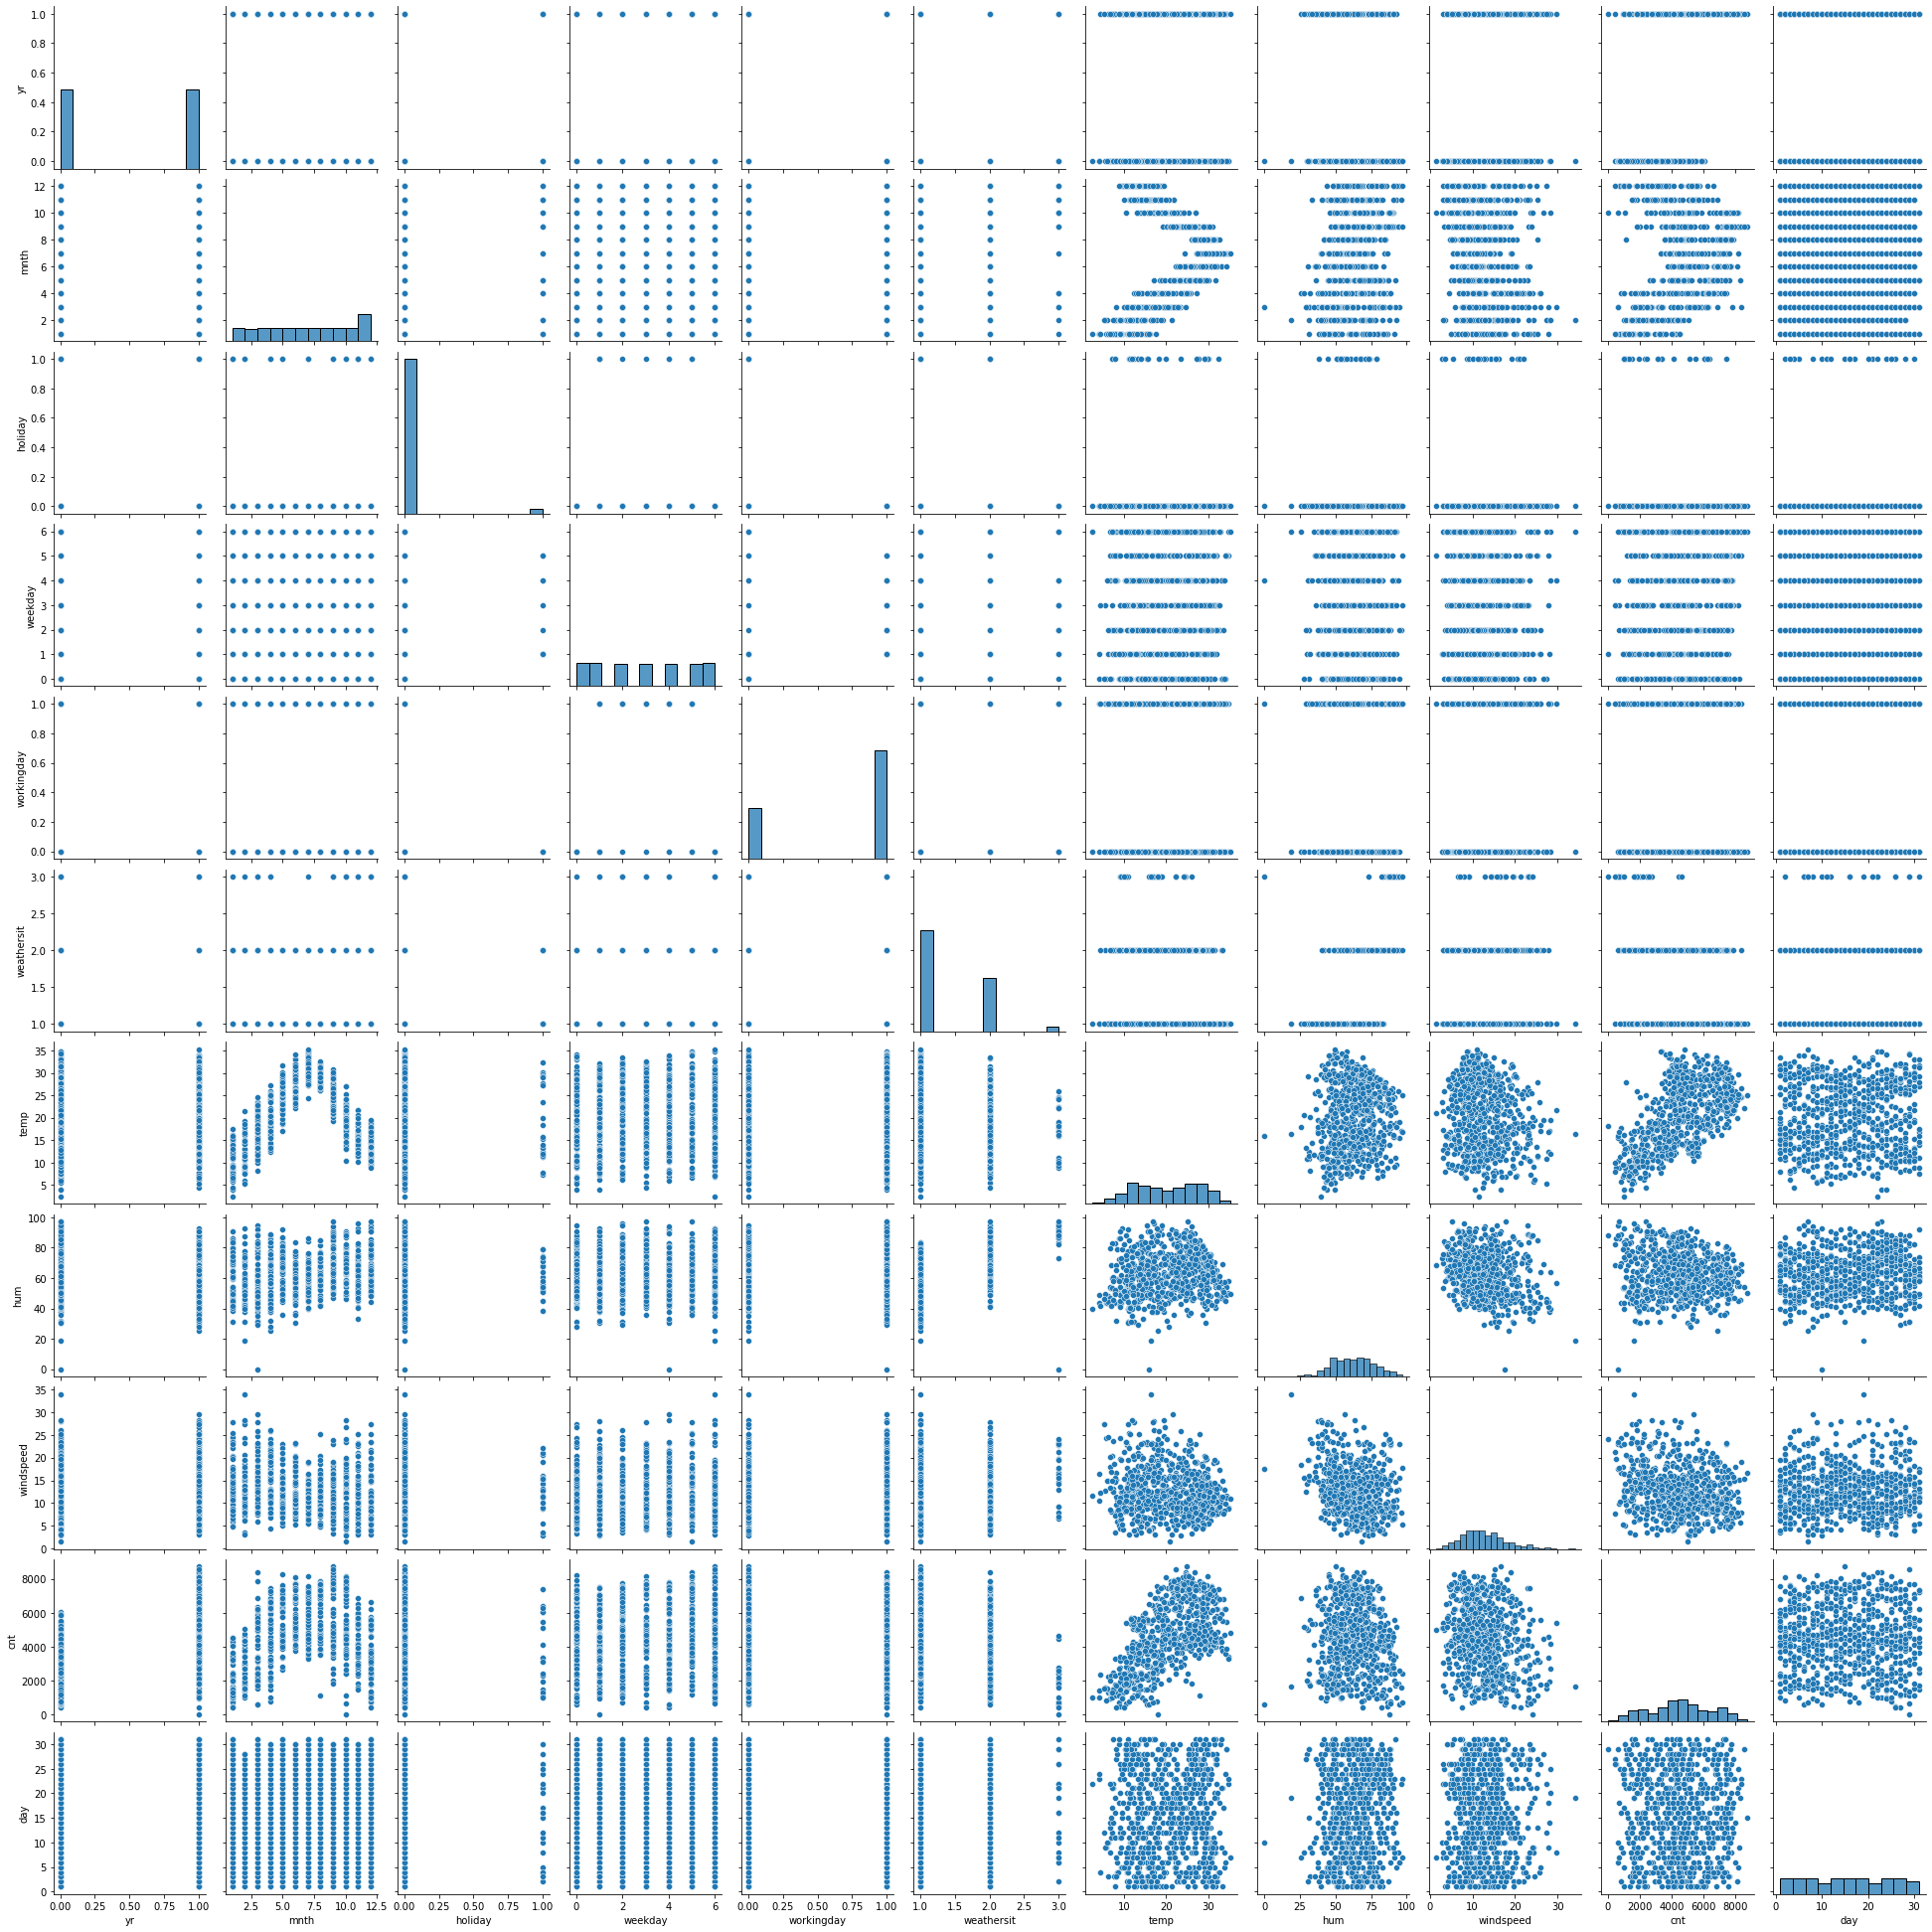

In [20]:
sns.pairplot(df)

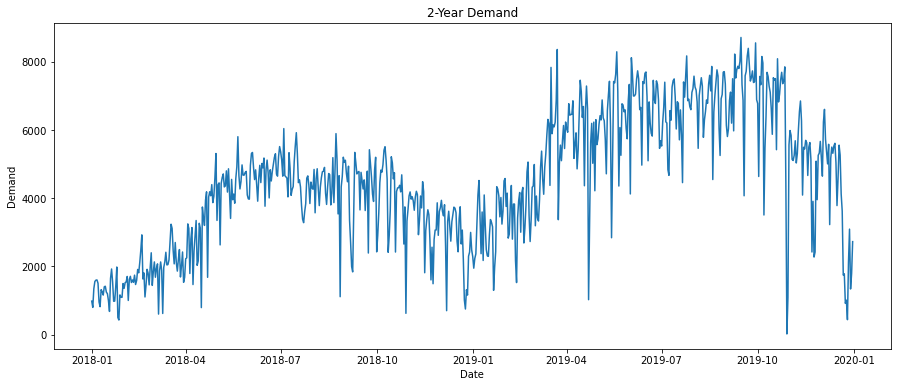

In [21]:
plt.figure(figsize=(15,6))
plt.plot(df['dteday'],df['cnt'])
plt.xlabel('Date')
plt.ylabel('Demand')
plt.title('2-Year Demand')
plt.show()

Observations:
- high demand in the middle of the year
- trending upward (2019 demand > 2018 demand)
- positive correlation between temp and demand

### Regression

In [23]:

# data_df['Date'] = pd.to_datetime(data_df['Date'])
df['dteday'] = df['dteday'].map(dt.datetime.toordinal)

In [48]:
# Create traning and testing datasets

x = df.drop(['dteday', 'cnt'], axis = 1)
y = df['cnt']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)

In [24]:
# Create traning and testing datasets

x = df.drop(['yr', 'mnth', 'day', 'cnt'], axis = 1)
y = df['cnt']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)

Between the two, ```['yr', 'mnth', 'day', 'cnt']``` has better results than ```['dteday', 'cnt']```

In [25]:
# Identify the best model

regressors = {
    "LinearRegression": LinearRegression(),
    "XGBRegressor": XGBRegressor(silent=True),
    "RandomForestRegressor": RandomForestRegressor(),
    "DecisionTreeRegressor": DecisionTreeRegressor(),
    "GaussianProcessRegressor": GaussianProcessRegressor(),
    "SVR": SVR(),
    "NuSVR": NuSVR(),
    "Ridge":Ridge(),
    "Lars": Lars(),
    "TheilSenRegressor": TheilSenRegressor(),
    "HuberRegressor": HuberRegressor(),
    "PassiveAggressiveRegressor": PassiveAggressiveRegressor(),
    "ARDRegression": ARDRegression(),
    "BayesianRidge": BayesianRidge(),
    "ElasticNet": ElasticNet(),
    "OrthogonalMatchingPursuit": OrthogonalMatchingPursuit(),
}

In [30]:
df_models = pd.DataFrame(columns=['model', 'run_time', 'rmse'])

for key in regressors:

    print('*',key)

    start_time = time.time()

    regressor = regressors[key]
    model = regressor.fit(x_train, y_train)
    y_pred = model.predict(x_test)

    scores = cross_val_score(model, 
                             x_train, 
                             y_train,
                             scoring="neg_mean_squared_error", 
                             cv=10)

    row = {'model': key,
           'run_time': format(round((time.time() - start_time)/60,2)),
           'rmse': round(np.sqrt(mean_squared_error(y_test, y_pred))),
           'mape': mean_absolute_percentage_error(y_test, y_pred),
           'r2' : r2_score(y_test, y_pred)
    }

    df_models = df_models.append(row, ignore_index=True)

* LinearRegression
* XGBRegressor
[19:49:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[19:49:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[19:49:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not

C:\Temp\ipykernel_33112\1169059280.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_models = df_models.append(row, ignore_index=True)


[19:49:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[19:49:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[19:49:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false

C:\Temp\ipykernel_33112\1169059280.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_models = df_models.append(row, ignore_index=True)


* RandomForestRegressor


C:\Temp\ipykernel_33112\1169059280.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_models = df_models.append(row, ignore_index=True)
C:\Temp\ipykernel_33112\1169059280.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_models = df_models.append(row, ignore_index=True)


* DecisionTreeRegressor
* GaussianProcessRegressor


C:\Temp\ipykernel_33112\1169059280.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_models = df_models.append(row, ignore_index=True)
C:\Temp\ipykernel_33112\1169059280.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_models = df_models.append(row, ignore_index=True)


* SVR
*

C:\Temp\ipykernel_33112\1169059280.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_models = df_models.append(row, ignore_index=True)
C:\Temp\ipykernel_33112\1169059280.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_models = df_models.append(row, ignore_index=True)
C:\Users\isabe\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:133: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lars())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline a

 NuSVR
* Ridge
* Lars
* TheilSenRegressor


C:\Temp\ipykernel_33112\1169059280.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_models = df_models.append(row, ignore_index=True)
C:\Temp\ipykernel_33112\1169059280.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_models = df_models.append(row, ignore_index=True)
C:\Temp\ipykernel_33112\1169059280.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_models = df_models.append(row, ignore_index=True)


* HuberRegressor
* PassiveAggressiveRegressor
* ARDRegression
* BayesianRidge
* ElasticNet
* OrthogonalMatchingPursuit


C:\Temp\ipykernel_33112\1169059280.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_models = df_models.append(row, ignore_index=True)
C:\Temp\ipykernel_33112\1169059280.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_models = df_models.append(row, ignore_index=True)
C:\Temp\ipykernel_33112\1169059280.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_models = df_models.append(row, ignore_index=True)
C:\Users\isabe\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:133: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behav

In [31]:
# Order model results

df_models.head(20).sort_values(by='rmse', ascending=True)

,model,run_time,rmse,mape,r2
1,XGBRegressor,0.01,679,0.176784,0.890191
2,RandomForestRegressor,0.03,679,0.195039,0.890013
0,LinearRegression,0.0,989,0.248347,0.766715
8,Lars,0.0,989,0.248347,0.766715
7,Ridge,0.0,990,0.248550,0.766501
12,ARDRegression,0.0,996,0.253075,0.763441
13,BayesianRidge,0.0,1003,0.255736,0.759974
14,ElasticNet,0.0,1032,0.270045,0.746298
3,DecisionTreeRegressor,0.0,1036,0.254038,0.744024
15,OrthogonalMatchingPursuit,0.0,1618,0.484993,0.375995


In [64]:
# Assess the best model

regressor = XGBRegressor(silent=True)
model = regressor.fit(x_train, y_train)
y_pred = model.predict(x_test)

[14:39:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




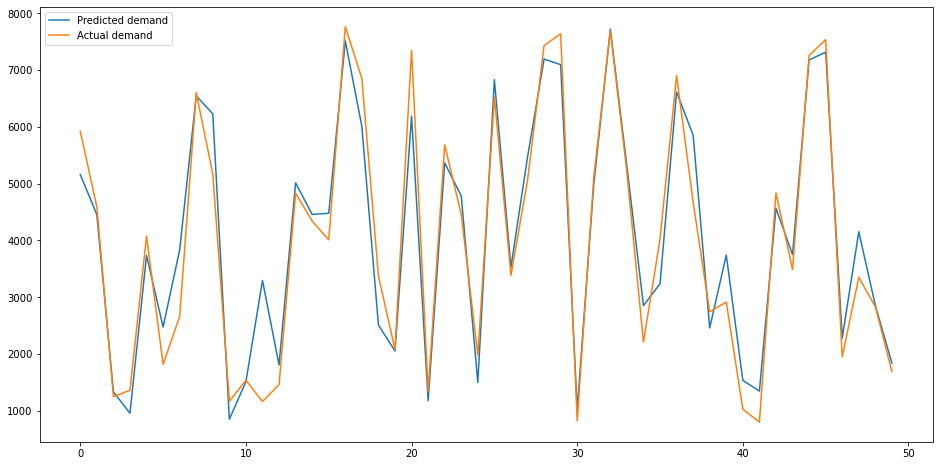

In [65]:
# Plot

test = pd.DataFrame({'Predicted demand':y_pred, 'Actual demand':y_test})
fig= plt.figure(figsize=(16,8))
test = test.reset_index()
test = test.drop(['index'],axis=1)
plt.plot(test[:50])
plt.legend(['Predicted demand','Actual demand'])

Data Source: https://www.kaggle.com/datasets/yasserh/bike-sharing-dataset